## Time Series Forecasting for Sales Units Using SARIMAX Model 
The code imports necessary libraries for time series analysis and data visualization. The data is then read in from a CSV file located in a Github repository and preprocessed to create a dataframe of sold units grouped by country code and date. The code checks the stationarity of the data using the Dickey-Fuller test and plots the rolling mean and standard deviation. If the data is not stationary, it is then made stationary by differencing the data. The code then performs a grid search to find the best SARIMAX model by fitting multiple models with different hyperparameters and selecting the model with the lowest AIC (Akaike Information Criterion). The best model is then used to make predictions on the data and the results are plotted.

##### Importing The necassary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import itertools
import statsmodels.api as sm

from itertools import product
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

### Data understanding

##### Importing the data from my GitHub repository

In [2]:
url = 'https://raw.githubusercontent.com/BHAJansen/Individual-porfolio/main/Historical_Data.csv'
data = pd.read_csv(url) #Data frame is being imported and named is named data
data

,Date,Article_ID,Country_Code,Sold_Units
0,20170817,1132,AT,1
1,20170818,1132,AT,1
2,20170821,1132,AT,1
3,20170822,1132,AT,1
4,20170906,1132,AT,1
...,...,...,...,...
4844,20181211,5972,SE,1
4845,20190101,5972,SE,3
4846,20190120,5972,SE,1
4847,20190123,5972,SE,1


In [3]:
data.describe()

,Date,Article_ID,Sold_Units
count,4.849000e+03,4849.00000,4849.000000
mean,2.017794e+07,2314.55331,1.966797
std,5.981690e+03,1813.23926,2.373171
min,2.017010e+07,332.00000,1.000000
25%,2.017093e+07,409.00000,1.000000
50%,2.018041e+07,1923.00000,1.000000
75%,2.018092e+07,3448.00000,2.000000
max,2.019021e+07,5984.00000,101.000000


In [4]:
data.Country_Code.unique()

array(['AT', 'FI', 'FR', 'SE'], dtype=object)

### Data preperation

#####  Changing the column 'Date' to a string value and column 'Country_Code' to categorical value

In [5]:
def preprocess(data):        
    data['Date'] = pd.to_datetime(data.Date.astype('str'), errors='raise')
    data['Country_Code'] = data.Country_Code.astype('category')
    print(data.info(), end='\n\n')
    print(data.head())
    
preprocess(data)
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4849 entries, 0 to 4848
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          4849 non-null   datetime64[ns]
 1   Article_ID    4849 non-null   int64         
 2   Country_Code  4849 non-null   category      
 3   Sold_Units    4849 non-null   int64         
dtypes: category(1), datetime64[ns](1), int64(2)
memory usage: 118.7 KB
None

        Date  Article_ID Country_Code  Sold_Units
0 2017-08-17        1132           AT           1
1 2017-08-18        1132           AT           1
2 2017-08-21        1132           AT           1
3 2017-08-22        1132           AT           1
4 2017-09-06        1132           AT           1


,Date,Article_ID,Country_Code,Sold_Units
0,2017-08-17,1132,AT,1
1,2017-08-18,1132,AT,1
2,2017-08-21,1132,AT,1
3,2017-08-22,1132,AT,1
4,2017-09-06,1132,AT,1
...,...,...,...,...
4844,2018-12-11,5972,SE,1
4845,2019-01-01,5972,SE,3
4846,2019-01-20,5972,SE,1
4847,2019-01-23,5972,SE,1


##### The data frame is being seperated by country code

In [6]:
def preprocess(data, country):        
    #set observed = True because Country_Code is category column
    df = data.groupby(['Country_Code', 'Date'], as_index=False, observed=True)['Sold_Units'].sum()        
    df_country = df.loc[df.Country_Code==country, :].set_index(['Date', 'Country_Code']).unstack(fill_value=0).asfreq('D', fill_value=0).stack().sort_index(level=1).reset_index()
    df_country_sorted = df_country.sort_values(['Date'], ascending=True)
    return (country, df_country_sorted)

##### The new data frames for each country code are stored in country_dfs

In [7]:
#preprocess data for each country
country_dfs = {}
for country in data.Country_Code.unique():
    country, df = preprocess(data, country)
    country_dfs[country] = df
country_dfs

{'AT':           Date Country_Code  Sold_Units
 0   2017-01-01           AT           1
 1   2017-01-02           AT           0
 2   2017-01-03           AT           1
 3   2017-01-04           AT           0
 4   2017-01-05           AT           0
 ..         ...          ...         ...
 769 2019-02-09           AT           2
 770 2019-02-10           AT           7
 771 2019-02-11           AT           5
 772 2019-02-12           AT           4
 773 2019-02-13           AT           5
 
 [774 rows x 3 columns],
 'FI':           Date Country_Code  Sold_Units
 0   2017-01-02           FI           2
 1   2017-01-03           FI           2
 2   2017-01-04           FI           5
 3   2017-01-05           FI           3
 4   2017-01-06           FI           4
 ..         ...          ...         ...
 768 2019-02-09           FI           4
 769 2019-02-10           FI           4
 770 2019-02-11           FI           0
 771 2019-02-12           FI           2
 772 2019-02-13   

##### The function checks the stationarity of tha data by calculating relevent metrics

In [8]:
# Check for stationarity
def test_stationarity(timeseries):
    #Determine rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    #Perform Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
    #Plot rolling statistics
    fig, ax = plt.subplots(figsize=(25,5))
    ax.plot(timeseries, label='Original')
    ax.plot(rolmean, label='Rolling Mean')
    ax.plot(rolstd, label='Rolling Std')
    ax.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

##### The function is being implemented for each country code data and the results are being plotted


Testing stationarity for country code: AT
ADF Statistic: -3.587258
p-value: 0.006009
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


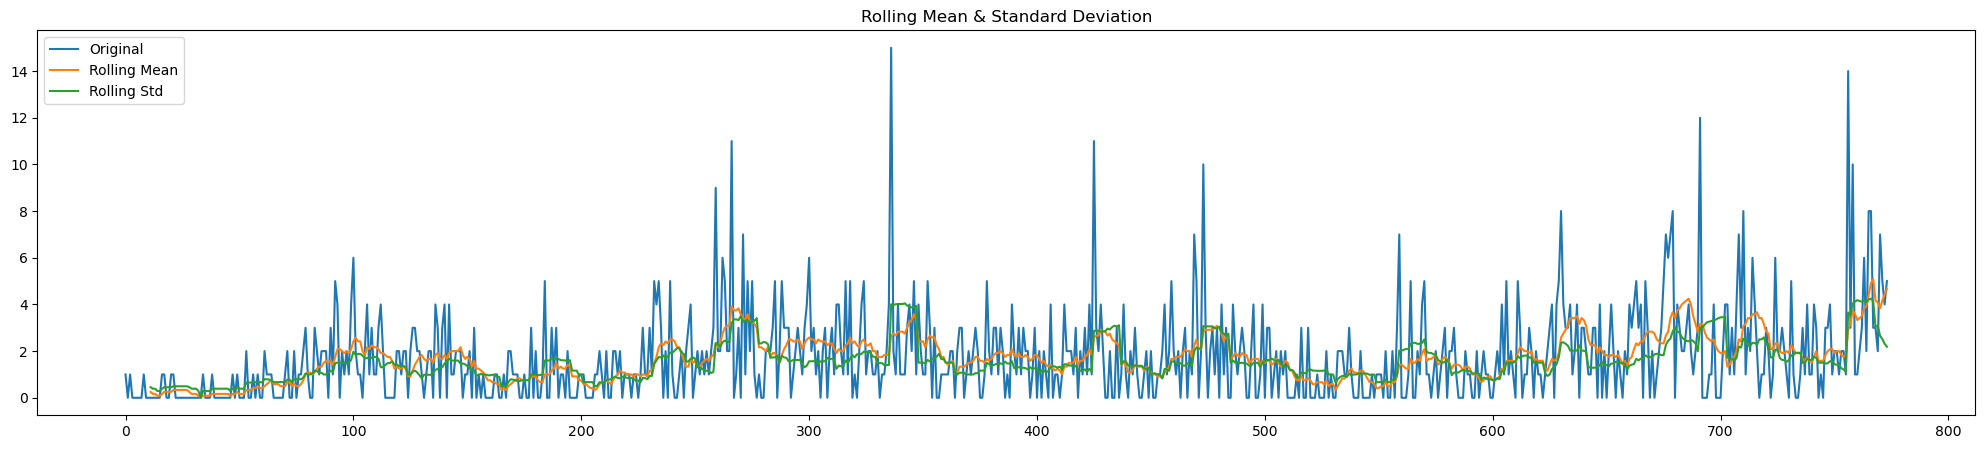


Testing stationarity for country code: FI
ADF Statistic: -6.833632
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


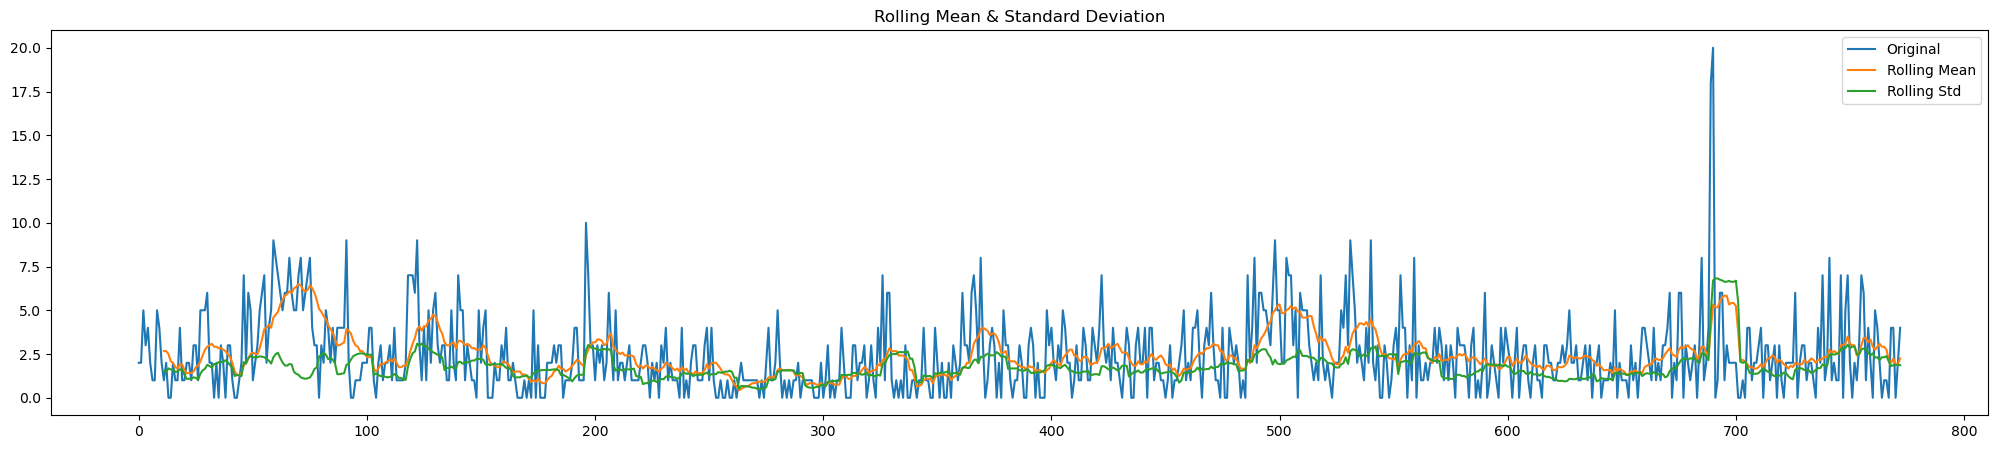


Testing stationarity for country code: FR
ADF Statistic: -3.893493
p-value: 0.002083
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


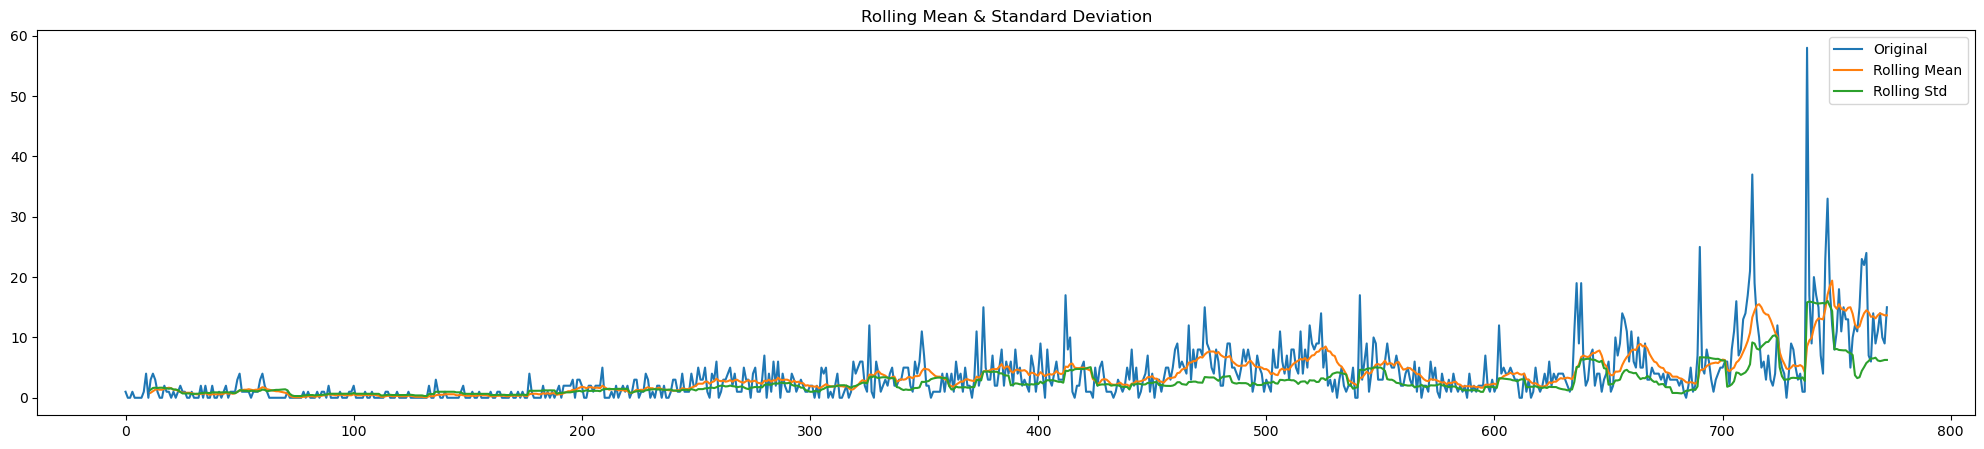


Testing stationarity for country code: SE
ADF Statistic: -8.588147
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


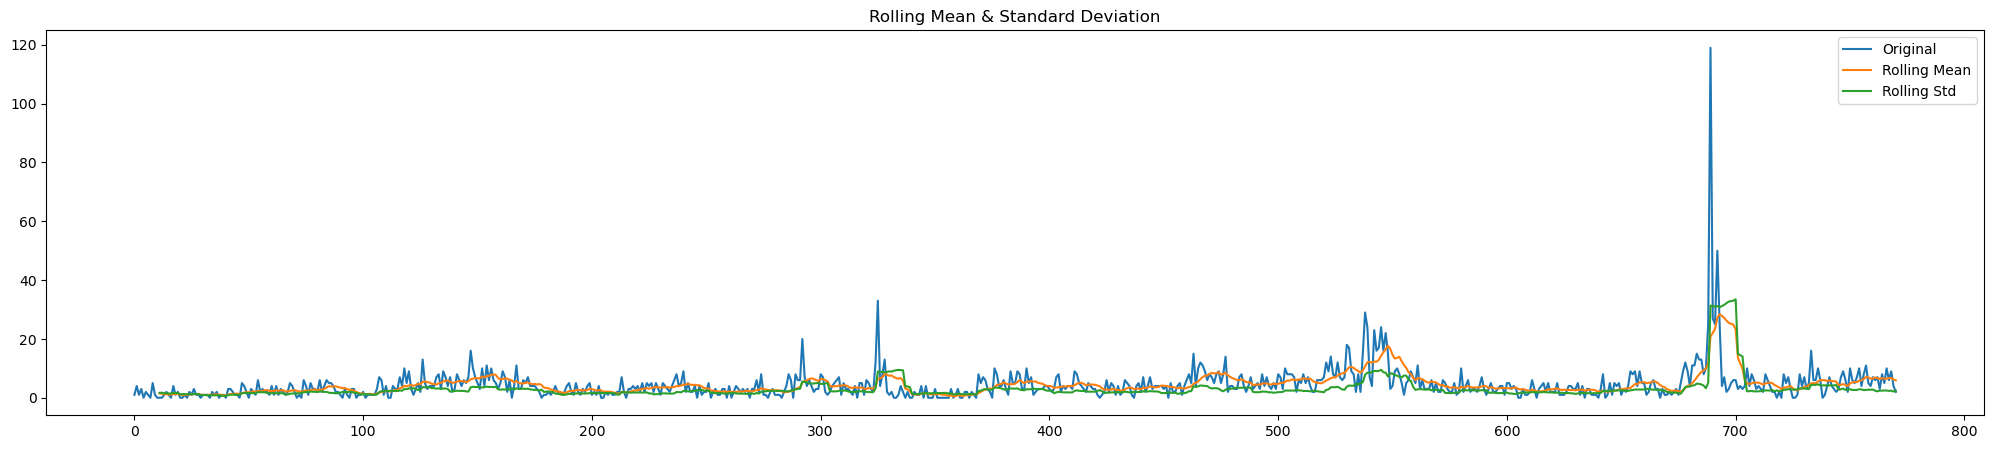


Making data stationary for country code: AT

Making data stationary for country code: FI

Making data stationary for country code: FR

Making data stationary for country code: SE


In [9]:
# Test stationarity for each country code data    
for country, df in country_dfs.items():
    print(f'\nTesting stationarity for country code: {country}')
    test_stationarity(df['Sold_Units'])
    
#Make the data stationary
def make_stationary(timeseries):
    #Difference the data
    timeseries_diff = timeseries - timeseries.shift(1)
    timeseries_diff = timeseries_diff.dropna()
    
    return timeseries_diff

# Make the data stationary for each country code data    
stationary_country_dfs = {}
for country, df in country_dfs.items():
    print(f'\nMaking data stationary for country code: {country}')
    stationary_data = make_stationary(df['Sold_Units'])
    stationary_country_dfs[country] = stationary_data

##### The data is tested again for stationarity after making it stationair. The results are being plotted.


Testing stationarity for country code: AT after making it stationary
ADF Statistic: -13.518183
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


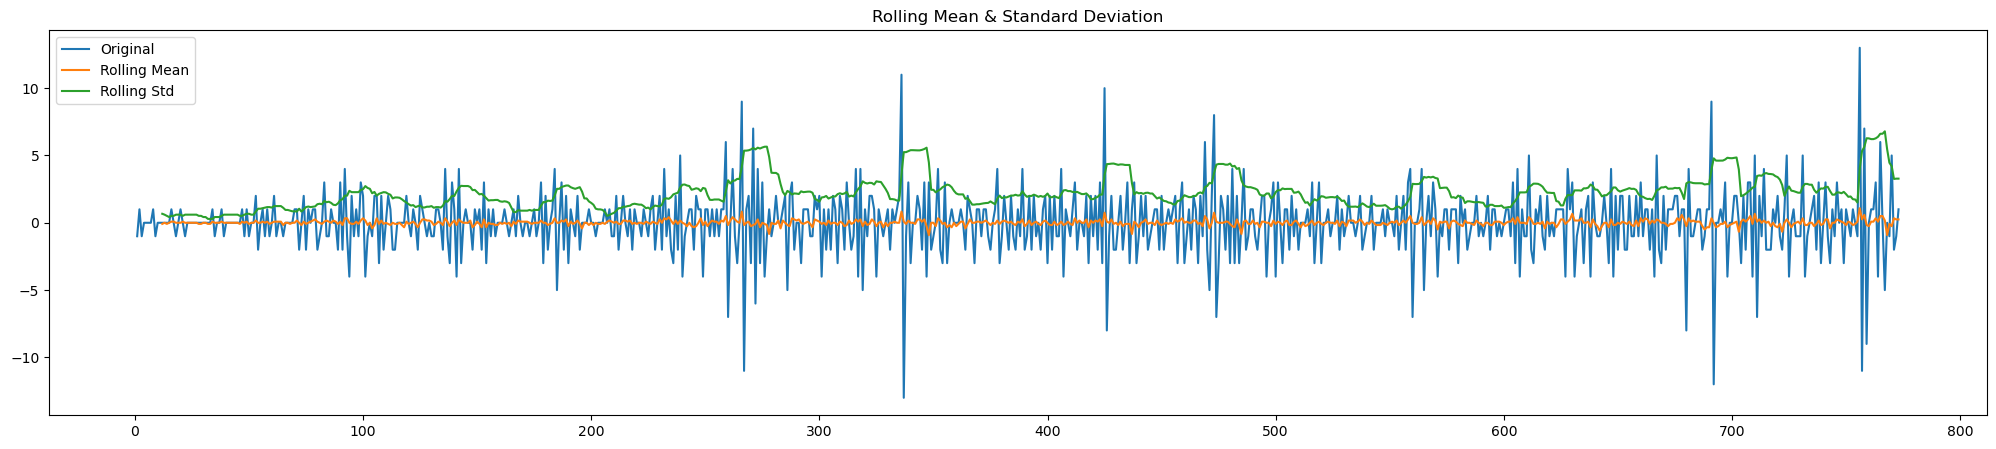


Testing stationarity for country code: FI after making it stationary
ADF Statistic: -10.246427
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


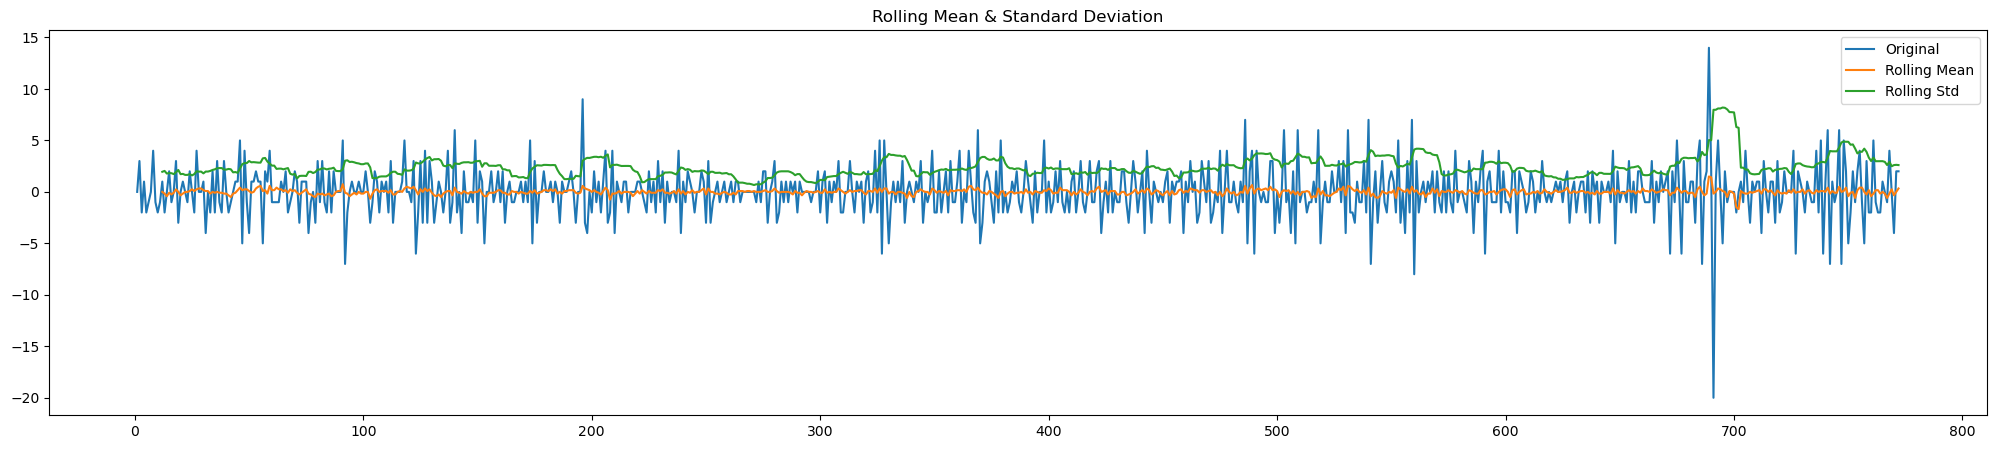


Testing stationarity for country code: FR after making it stationary
ADF Statistic: -10.200780
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


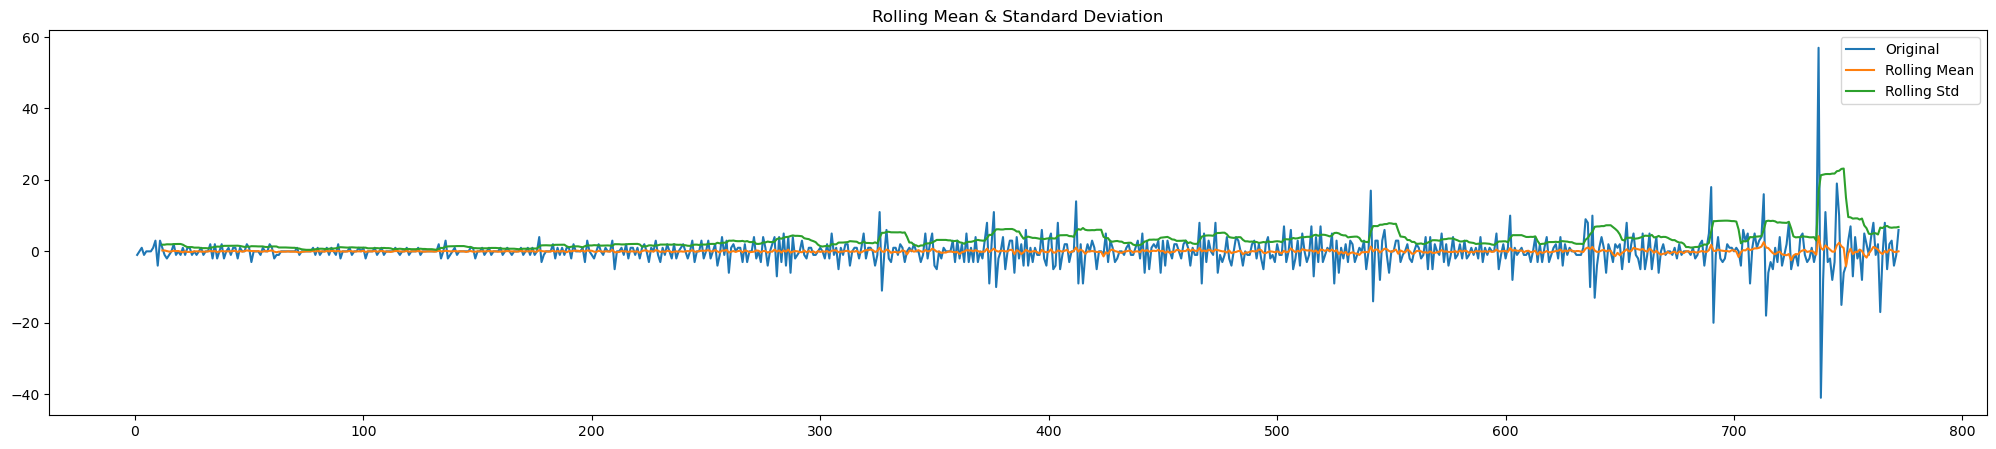


Testing stationarity for country code: SE after making it stationary
ADF Statistic: -13.301051
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


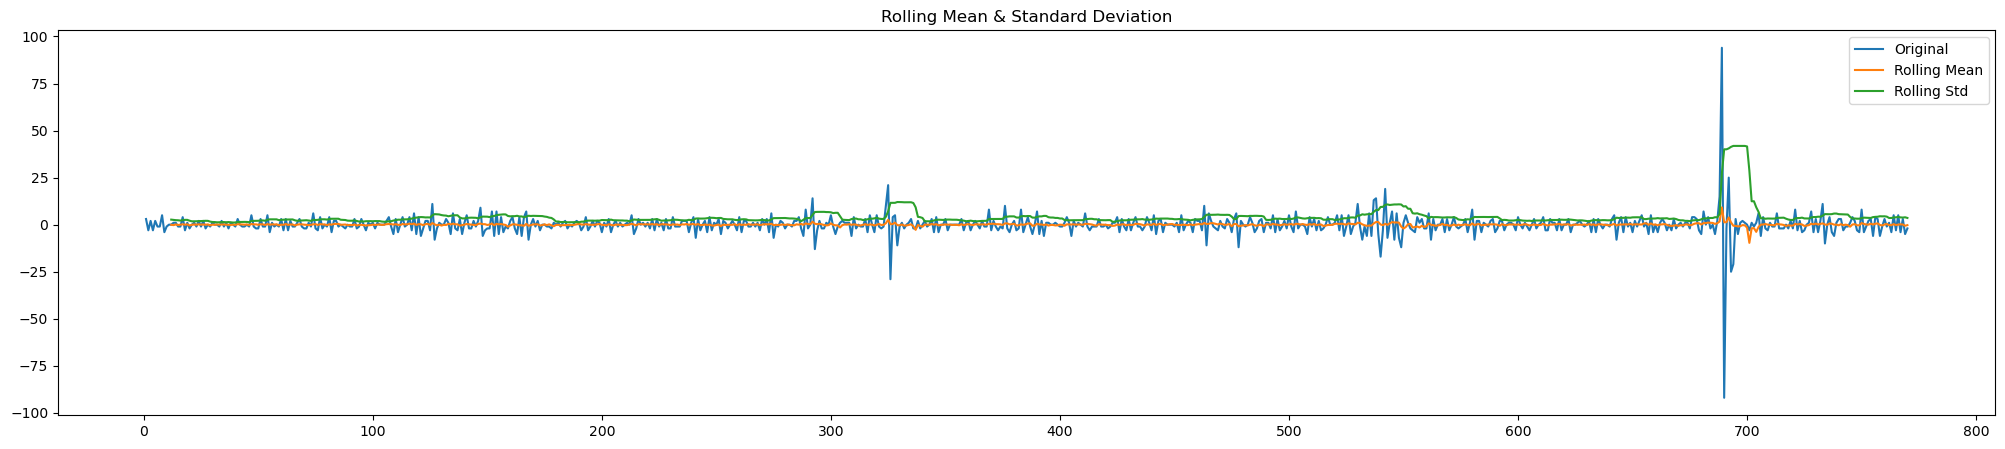

In [10]:
# Test stationarity for each country code data after making it stationary    
for country, df in stationary_country_dfs.items():
    print(f'\nTesting stationarity for country code: {country} after making it stationary')
    test_stationarity(df)

#### Now that the data is stationary (p-value is completly 0), the SARIMAX model can be implemented
##### SARIMAX model is being implemented

In [11]:
# Define a function to fit SARIMAX models and calculate their AIC (Akaike Information Criterion)
def fit_sarimax(data, order, seasonal_order):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        mod = sm.tsa.SARIMAX(data, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
        results = mod.fit()
        return results.aic

# Define a function to perform a grid search to find the best SARIMAX model
def grid_search_sarimax(data):
    # Define the hyperparameter search space
    p_vals = range(0, 2)
    d_vals = range(0, 2)
    q_vals = range(0, 2)
    P_vals = range(0, 2)
    D_vals = range(0, 2)
    Q_vals = range(0, 2)
    m_vals = [12]
    
    # Generate all possible combinations of hyperparameters
    hyperparameters = list(itertools.product(p_vals, d_vals, q_vals, P_vals, D_vals, Q_vals, m_vals))
    hyperparameters = [(x[0], x[1], x[2], x[3], x[4], x[5], x[6]) for x in hyperparameters if x[4] <= x[1]]
    
    # Fit SARIMAX models for all possible combinations of hyperparameters and calculate their AIC
    aics = []
    for hyperparameter in hyperparameters:
        aic = fit_sarimax(data, order=hyperparameter[:3], seasonal_order=hyperparameter[3:])
        aics.append((aic, hyperparameter))
    
    # Find the SARIMAX model with the lowest AIC
    best_aic, best_hyperparameter = sorted(aics)[0]
    best_model = sm.tsa.SARIMAX(data, order=best_hyperparameter[:3], seasonal_order=best_hyperparameter[3:])
    return best_model.fit()
    

##### The SARIMAX model is being implemented to the stationary data, the results and forcast is being plotted.


Fitting SARIMAX model for country code: AT


C:\Users\bramj\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\bramj\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\bramj\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


                                     SARIMAX Results                                      
Dep. Variable:                         Sold_Units   No. Observations:                  773
Model:             SARIMAX(0, 0, 1)x(0, 0, 1, 12)   Log Likelihood               -1552.543
Date:                            Wed, 08 Feb 2023   AIC                           3111.085
Time:                                    22:07:51   BIC                           3125.036
Sample:                                         0   HQIC                          3116.453
                                            - 773                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9297      0.012    -76.339      0.000      -0.954      -0.906
ma.S.L12       0.0682      0.033   

C:\Users\bramj\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\bramj\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\bramj\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


                                     SARIMAX Results                                      
Dep. Variable:                         Sold_Units   No. Observations:                  772
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 12)   Log Likelihood               -1645.143
Date:                            Wed, 08 Feb 2023   AIC                           3298.285
Time:                                    22:08:03   BIC                           3316.881
Sample:                                         0   HQIC                          3305.441
                                            - 772                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2214      0.026      8.588      0.000       0.171       0.272
ma.L1         -0.9329      0.014   

C:\Users\bramj\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\bramj\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                         Sold_Units   No. Observations:                  772
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood               -2083.559
Date:                            Wed, 08 Feb 2023   AIC                           4177.119
Time:                                    22:08:16   BIC                           4200.364
Sample:                                         0   HQIC                          4186.064
                                            - 772                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2584      0.027      9.553      0.000       0.205       0.311
ma.L1         -0.9301      0.012   

C:\Users\bramj\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\bramj\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\bramj\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\bramj\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


                                     SARIMAX Results                                      
Dep. Variable:                         Sold_Units   No. Observations:                  770
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 12)   Log Likelihood               -2368.551
Date:                            Wed, 08 Feb 2023   AIC                           4745.103
Time:                                    22:08:31   BIC                           4763.688
Sample:                                         0   HQIC                          4752.255
                                            - 770                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2187      0.015     14.269      0.000       0.189       0.249
ma.L1         -0.8470      0.011   

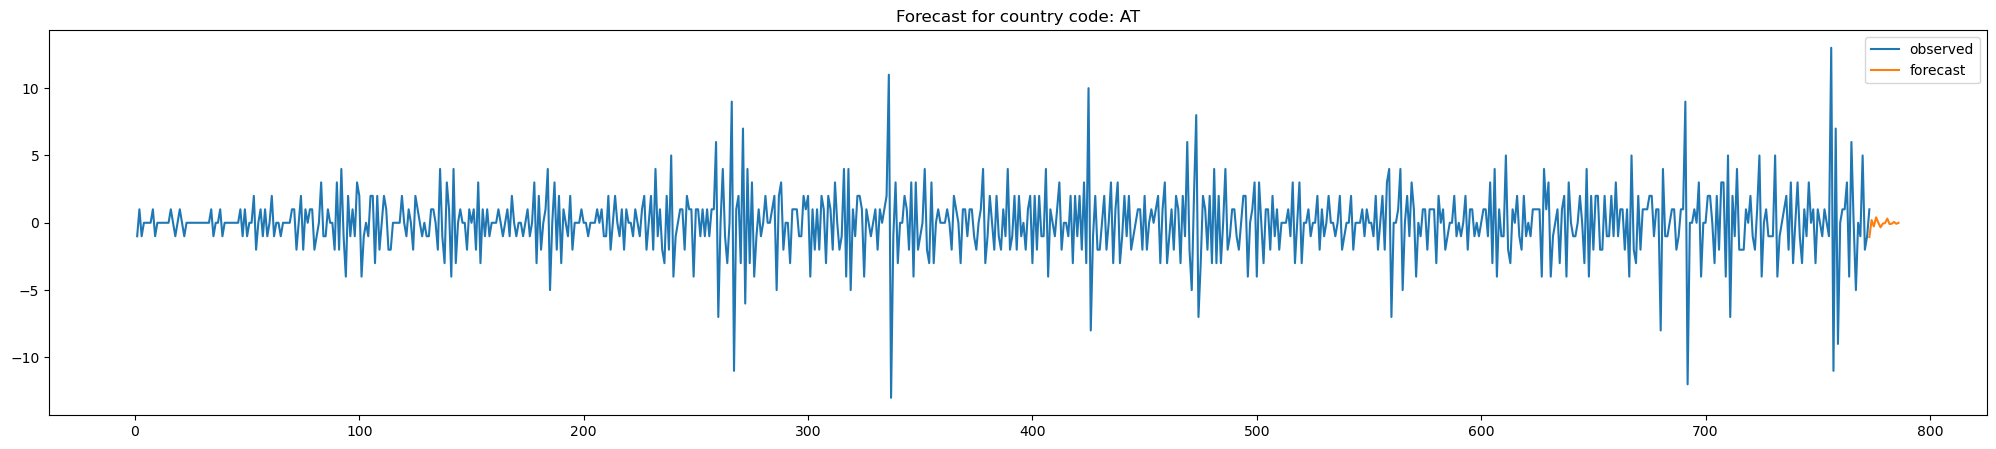

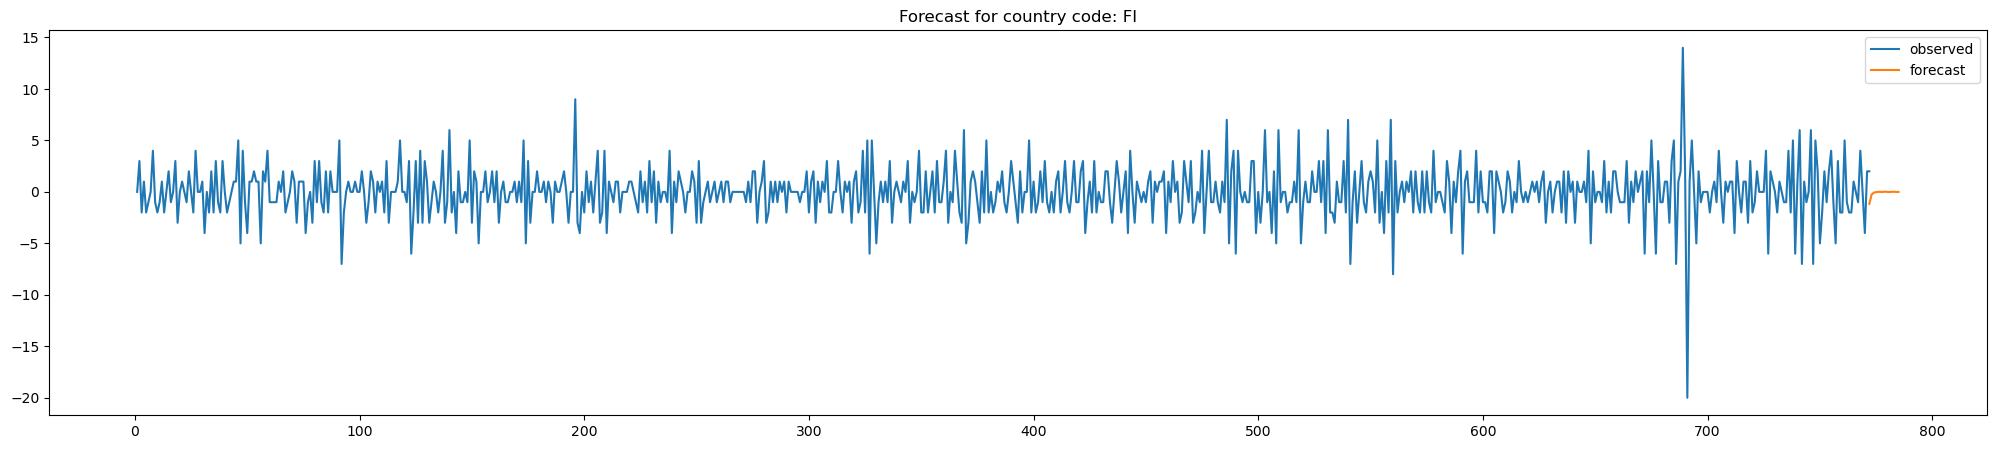

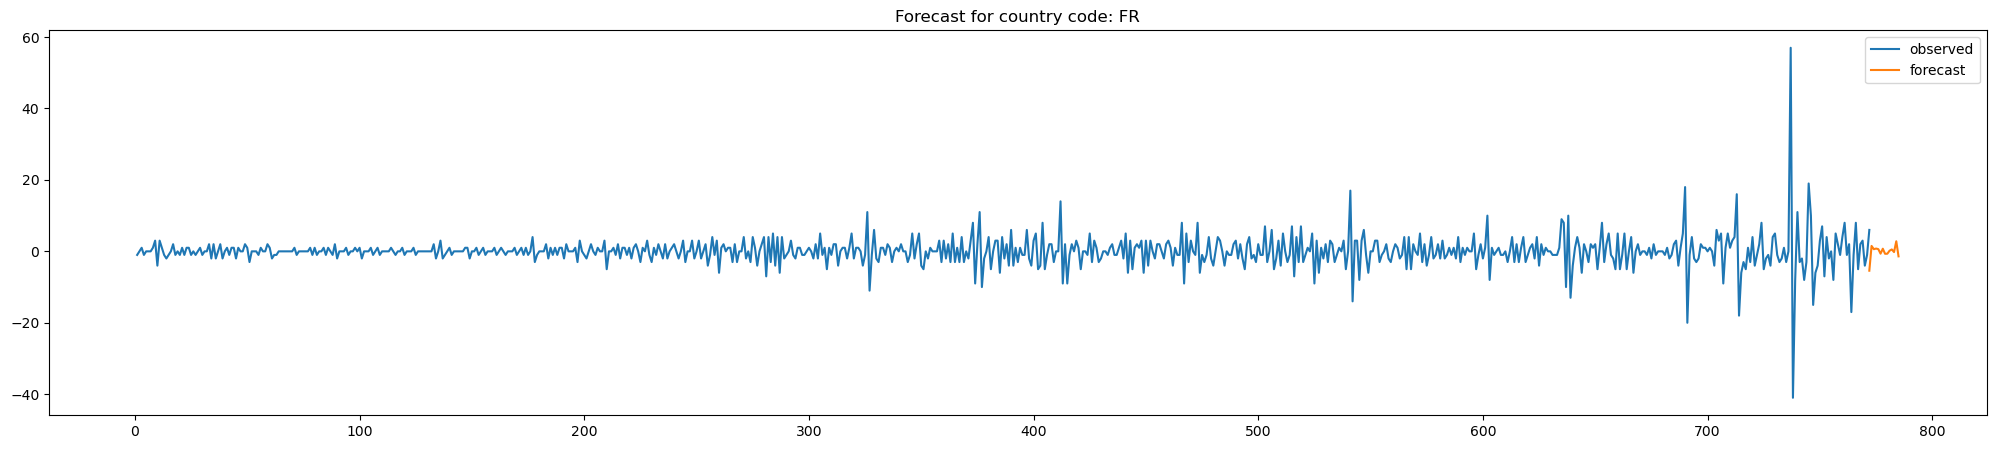

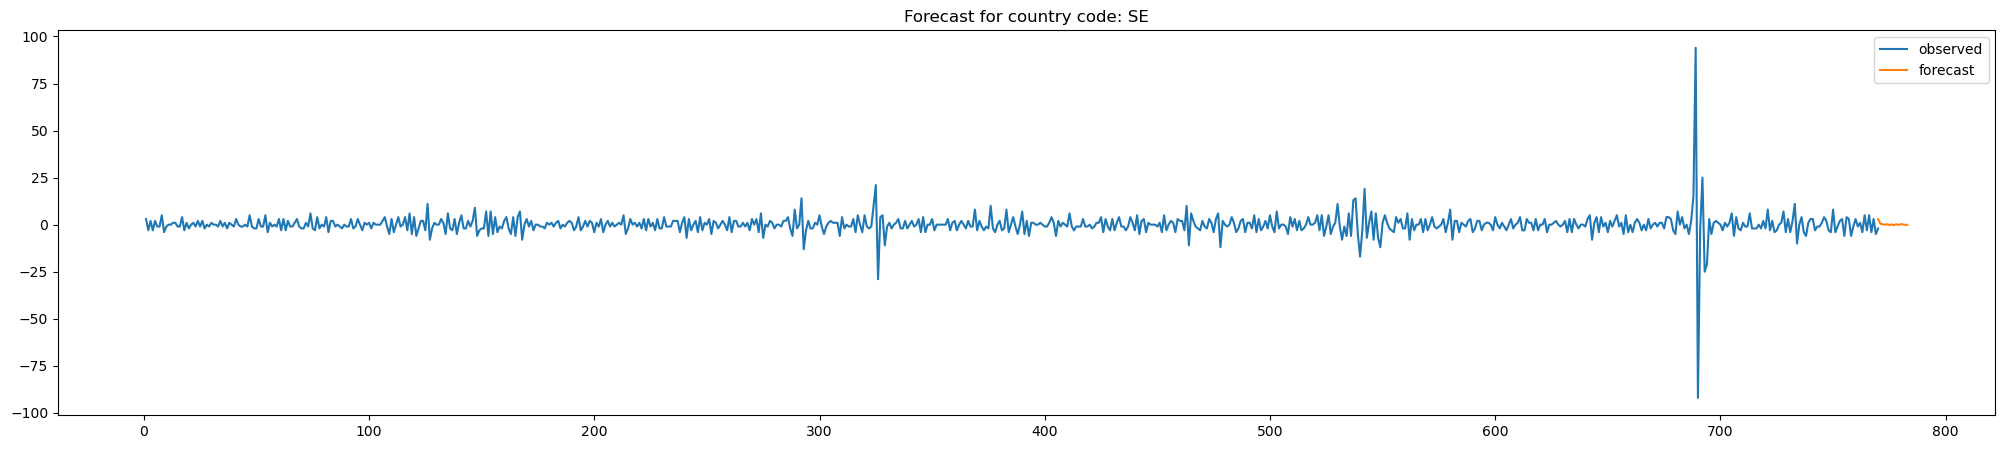

In [12]:
# Fit SARIMAX model to stationary data for each country code data    
for country, df in stationary_country_dfs.items():
    print(f'\nFitting SARIMAX model for country code: {country}')
    results = grid_search_sarimax(df)
    print(results.summary())
    
    # Use the best SARIMAX model to predict the future
    n_steps = 14
    future_forecast = results.get_forecast(steps=n_steps)
    mean_forecast = future_forecast.predicted_mean
    
# Plot the forecast for each country separately
    plt.figure(figsize=(25, 5))
    plt.plot(df, label='observed')
    plt.plot(mean_forecast, label='forecast')
    plt.legend()
    plt.title(f'Forecast for country code: {country}')